## Introduction
Shopping can be hard for women. From inconsistent sizing to overwhelming options, finding the perfect fit is often a difficult task. The same size could mean different things across different brands. How stressful is this!

In this project, we use clothing fit datasets from ModCloth and RentTheRunway to predict whether an item will fit a user as ‘small’, ‘fit’, or ‘large’ to understand which user and item features are most informative for predicting fit and creating accurate recommendations across various clothing categories.

In [89]:
# Imports
import gzip
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support,
                             make_scorer, f1_score)

In [90]:
# Helper function to open data
def open_file_df(path):
    rows = []
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in f:
            rows.append(json.loads(line))

    df = pd.DataFrame(rows)
    return df

In [91]:
# Load in data
df_rent = open_file_df('data/renttherunway_final_data.json.gz')
df_mod = open_file_df('data/modcloth_final_data.json.gz')

In [92]:
df_rent.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


In [93]:
df_mod.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29,7,5.0,d,38,34,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31,13,3.0,b,30,36,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30,7,2.0,b,NaN,32,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.00,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


## Preprocessing

We start with cleaning the RentTheRunway data.

In [94]:
# Deal with string cols
str_cols = ["fit", "bust size", "rented for", "review_text","body type", "review_summary", "category"]
df_rent[str_cols] = df_rent[str_cols].astype("string")

# Deal with int cols
int_cols = ["user_id", "item_id", "rating", "size", "age"]
for col in int_cols:
    df_rent[col] = pd.to_numeric(df_rent[col], errors='coerce').astype("Int64")

In [95]:
# Weight col
df_rent["weight"] = (df_rent["weight"].astype("string").str.extract(r"(\d+)", expand=False) .astype("float"))

# Height col helper function
def parse_height(x):
    if not isinstance(x, str):
        return np.nan

    # extract feet and inches
    m = re.match(r"^\s*(\d+)'\s*(\d+)?", x)
    if not m:
        return np.nan

    feet = float(m.group(1))
    inches = float(m.group(2)) if m.group(2) else 0.0

    return feet * 12 + inches

# Apply height cleaning function
df_rent["height_inches"] = df_rent["height"].apply(parse_height)

In [96]:
# Convert bust size to number(band) and letter(cup)

# Band col
df_rent["bust_band"] = (df_rent["bust size"].str.extract(r"(\d+)", expand=False).astype("float"))

# Cup col
df_rent["bust_cup"] = (df_rent["bust size"].str.extract(r"([a-zA-Z]+)", expand=False).str.upper())

# Date col - use pd datetime
df_rent["review_date"] = pd.to_datetime(df_rent["review_date"], errors="coerce")

In [97]:
# Convert "cocktail" category in rented for column into "party"
df_rent['rented_for'] = df_rent['rented for'].replace('party: cocktail', 'party')

In [98]:
# Drop rows with age > 100
df_rent = df_rent[df_rent.age <= 100]

# Drop rows with age == 0
df_rent = df_rent[df_rent.age != 0]

# Drop rows with size > 40
df_rent = df_rent[df_rent['size'] <= 40]

In [99]:
# Convert fit into numerical labels
fit_dict={'fit':0, 'small':-1, 'large':1}
df_rent.fit = df_rent.fit.apply(lambda x: fit_dict[x])

In [100]:
# Reduce categories from 68 to 10

# 10 categories definition
category_groups = {
    "dress": [
        "dress", "gown", "ballgown", "sheath", "shirtdress",
        "shift", "frock", "maxi", "mini", "midi"
    ],
    "jumpsuit/romper": [
        "jumpsuit", "romper", "overalls", "combo"
    ],
    "top": [
        "top", "blouse", "shirt", "tank", "tee", "t-shirt",
        "cami", "henley", "buttondown", "turtleneck", "blouson"
    ],
    "knitwear": [
        "sweater", "pullover", "knit", "cardigan", "crewneck",
        "hoodie", "sweatshirt", "sweatershirt"
    ],
    "pants": [
        "pants", "pant", "trouser", "trousers", "leggings",
        "legging", "jogger", "jeans", "culottes", "culotte",
        "sweatpants", "tight"
    ],
    "skirt": [
        "skirt", "skirts", "skort"
    ],
    "outerwear": [
        "jacket", "coat", "peacoat", "trench", "bomber",
        "blazer", "vest", "duster", "cape", "parka",
        "overcoat", "down"
    ],
    "ethnic/flowy": [
        "kaftan", "caftan", "kimono", "tunic", "poncho"
    ],
    "suit": ["suit"]
}

# make the map
category_map = {}
for new_cat, old_list in category_groups.items():
    for old_cat in old_list:
        category_map[old_cat] = new_cat

# apply mapping and set 'other' for unmapped
df_rent["category_clean"] = df_rent["category"].map(category_map).fillna("misc")


In [101]:
# Review text

In [102]:
#do this during pre processing for the model

cup_order = ["AA", "A", "B", "C", "D", "DD", "DDD", "E", "F", "G"]
#df_rent["bust_cup"] = pd.Categorical(df_rent["bust_cup"],categories=cup_order,ordered=True)

In [103]:
df_rent['fit_label'] = df_rent['fit'].map({-1: "small", 0: "fit", 1: "large"})
df_rent.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,height_inches,bust_band,bust_cup,rented_for,category_clean,fit_label
0,0,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,...,"5' 8""",14,28,2016-04-20,68.0,34.0,D,vacation,jumpsuit/romper,fit
1,0,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,...,"5' 6""",12,36,2013-06-18,66.0,34.0,B,other,dress,fit
3,0,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,...,"5' 5""",8,34,2014-02-12,65.0,34.0,C,formal affair,dress,fit
4,0,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,...,"5' 9""",12,27,2016-09-26,69.0,34.0,B,wedding,dress,fit
5,0,734848,32b,364092,138.0,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,...,"5' 8""",8,45,2016-04-30,68.0,32.0,B,date,dress,fit


now cleaning modcloth dataset

## EDA - RentTheRunway

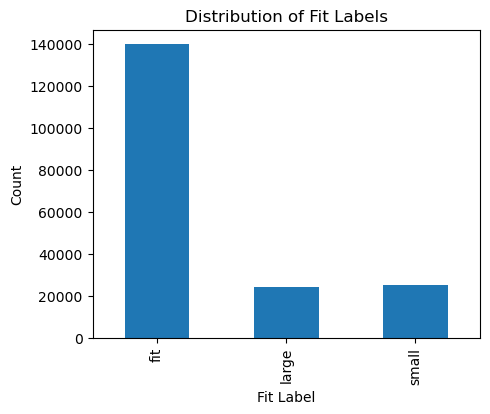

In [104]:
# Distribution of fit labels
plt.figure(figsize=(5,4))
df_rent['fit_label'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Fit Labels")
plt.xlabel("Fit Label")
plt.ylabel("Count")
plt.show()

The bar chart above shows a class imbalance with the majority of items fitting correctly, while "small" and "large" fit issues each represent only a small number of cases, which will require careful handling during model training to avoid biased predictions toward the majority "fit" class.

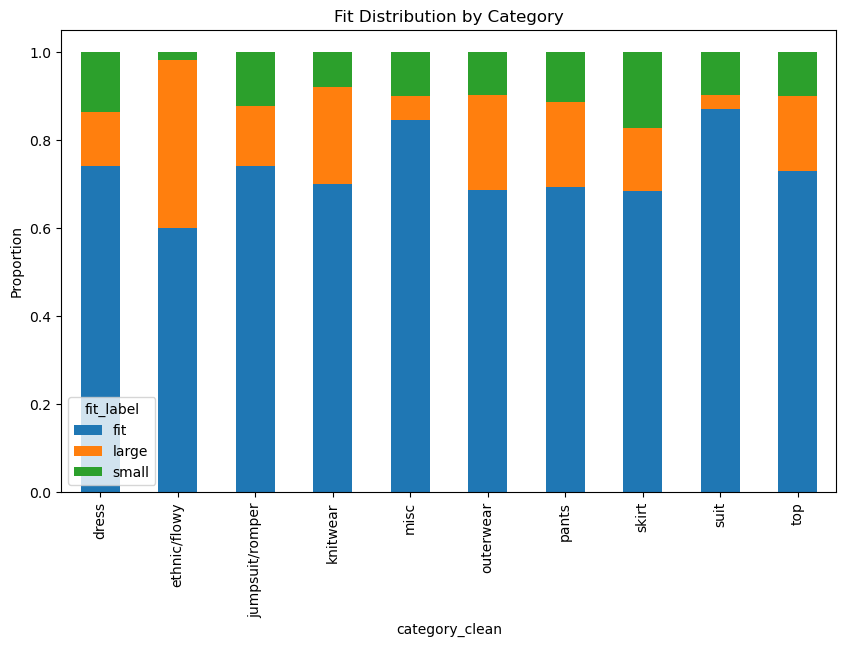

In [105]:
# Fit distribution by category
fit_by_cat = df_rent.groupby("category_clean")['fit_label'].value_counts(normalize=True).unstack()
fit_by_cat.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Fit Distribution by Category")
plt.ylabel("Proportion")
plt.show()

Fit proportions vary moderately across clothing categories, with ethnic/flowy items showing the highest rate of large fit issues while suits have the highest fit rate, suggesting that category-specific features will be important predictors in the model.

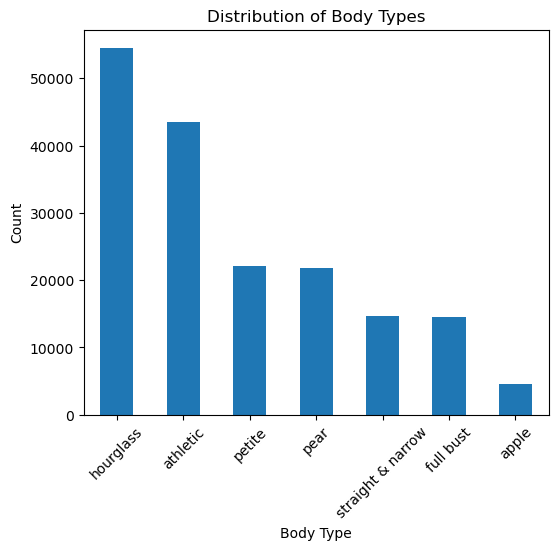

In [106]:
# Body type distribution
plt.figure(figsize=(6,5))
df_rent["body type"].value_counts().plot(kind="bar")
plt.title("Distribution of Body Types")
plt.xlabel("Body Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The chart above shows that the data is dominated by hourglass (~56,000) and athletic (~43,000) body types, with petite, pear, full bust, and straight & narrow body types moderately represented, and apple body type is significantly underrepresented (~5,000). This creates an imbalanced distribution that may affect model performance for less common body types.

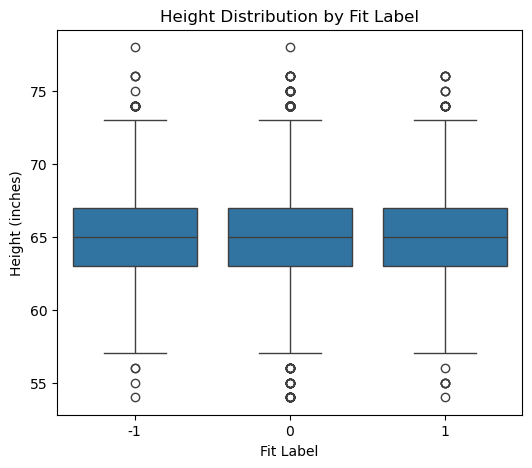

In [107]:
# Comparison of height vs fit
plt.figure(figsize=(6,5))
sns.boxplot(data=df_rent, x="fit", y="height_inches")
plt.title("Height Distribution by Fit Label")
plt.xlabel("Fit Label")
plt.ylabel("Height (inches)")
plt.show()

Height shows nearly no relationship with fit label, as all three categories (small=-1, fit=0, large=1) have nearly identical distributions with medians around 65 inches and similar spreads, suggesting height alone is not a strong predictor of clothing fit.

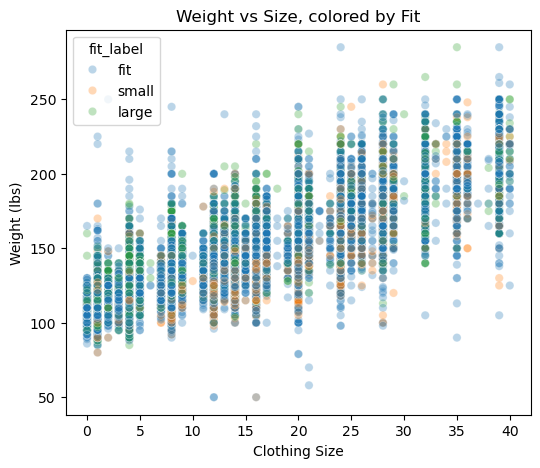

In [108]:
# Scatter plot of weight vs size
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_rent, x="size", y="weight", hue="fit_label", alpha=0.3)
plt.title("Weight vs Size, colored by Fit")
plt.xlabel("Clothing Size")
plt.ylabel("Weight (lbs)")
plt.show()

The scatter plot above shows overlap of all three fit categories across the weight-size spectrum, with no clear separation between "fit" (blue), "small" (orange), and "large" (green) labels. This suggests that predicting fit requires additional features beyond just weight and size, such as body type, garment category, or body proportions.

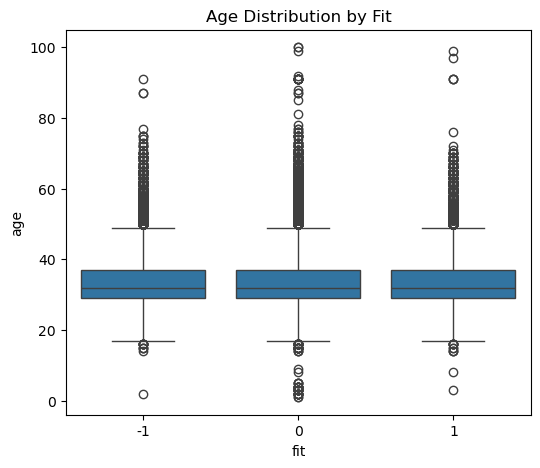

In [109]:
# Fit trends by age
plt.figure(figsize=(6,5))
sns.boxplot(data=df_rent, x="fit", y="age")
plt.title("Age Distribution by Fit")
plt.show()

The age distributions look very similar across all three fit categories, suggesting that age does not meaningfully influence whether an item runs small, true to size, or large.

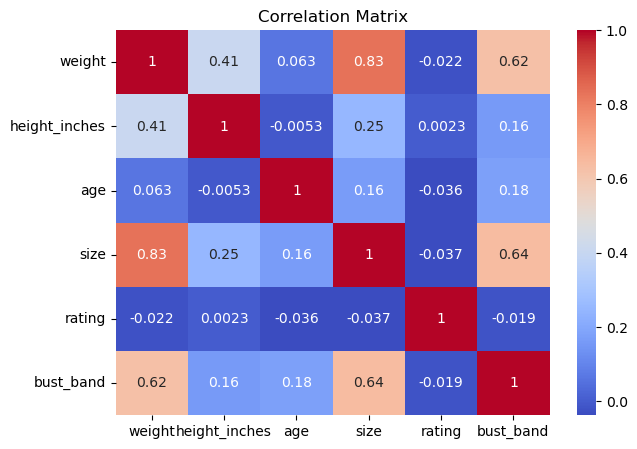

In [110]:
# Correlations of numeric features
numeric_cols = ["weight", "height_inches", "age", "size", "rating", "bust_band"]
corr = df_rent[numeric_cols].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

This correlation matrix above shows that weight has strong positive correlations with size (0.85) and bust_band (0.64). Most other variable pairs show weak correlations and the rating variable appears to be independent of physical measurements.

<Figure size 800x500 with 0 Axes>

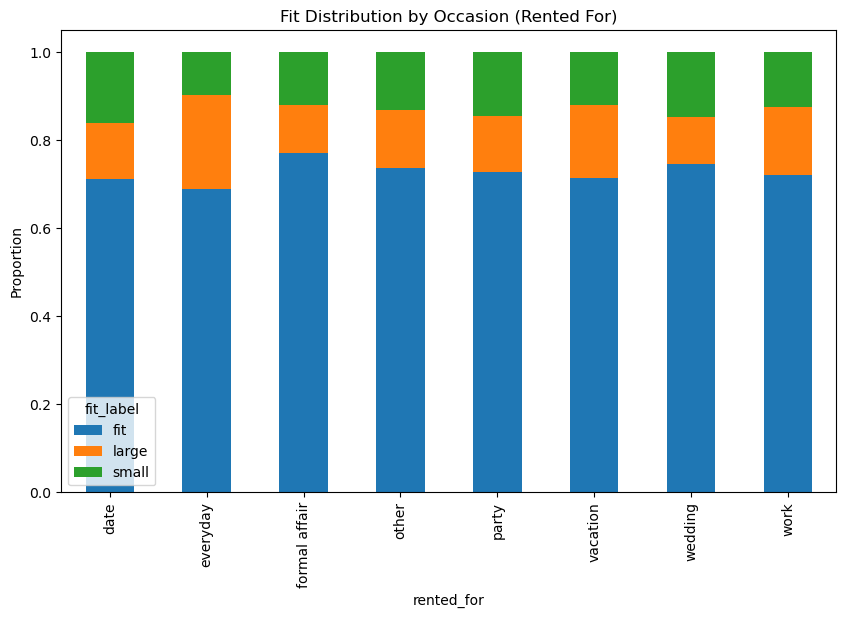

In [111]:
# Fit vs reason for renting
plt.figure(figsize=(8,5))
df_rent.groupby("rented_for")["fit_label"].value_counts(normalize=True).unstack().plot(
    kind="bar", stacked=True, figsize=(10,6)
)
plt.title("Fit Distribution by Occasion (Rented For)")
plt.ylabel("Proportion")
plt.show()


This stacked bar chart shows that across all rental occasions, the majority of items fit correctly with large being more common than small among the misfits. Fit proportions remain relatively consistent regardless of the event type.

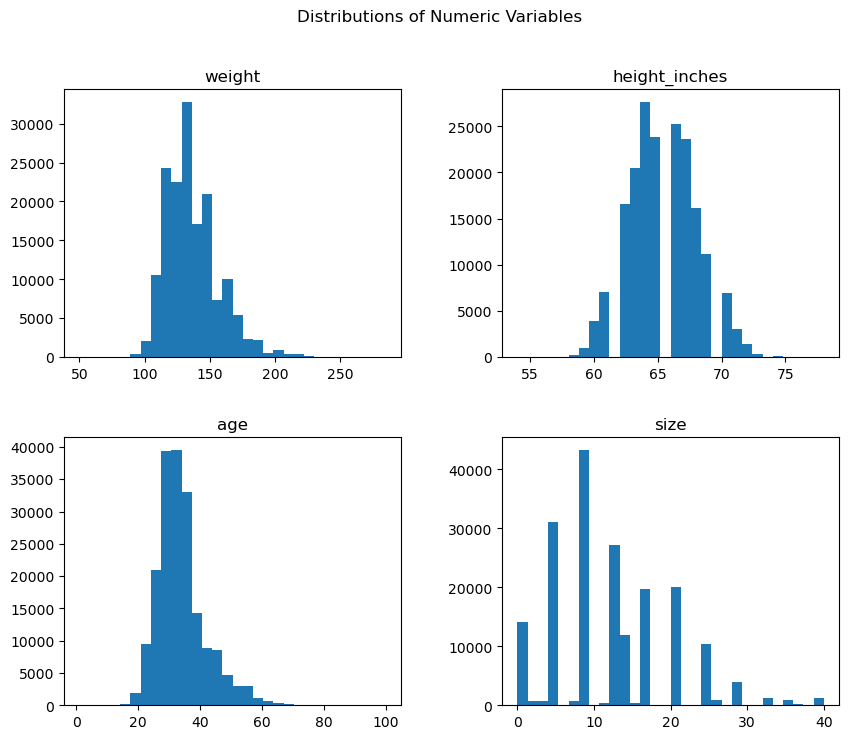

In [112]:
# Distribution of numeric features
df_rent[["weight","height_inches","age","size"]].hist(bins=30, figsize=(10,8), grid=False)
plt.suptitle("Distributions of Numeric Variables")
plt.show()

This figure shows the distributions of four numeric variables: weight is approximately normally distributed around 135 lbs, height clusters around 65-66 inches, age is right-skewed with most renters in their 30s, and size shows a  distribution with a peak smaller sizes around 8-10.

## Modeling

In [113]:
df_rent.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,height_inches,bust_band,bust_cup,rented_for,category_clean,fit_label
0,0,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,...,"5' 8""",14,28,2016-04-20,68.0,34.0,D,vacation,jumpsuit/romper,fit
1,0,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,...,"5' 6""",12,36,2013-06-18,66.0,34.0,B,other,dress,fit
3,0,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,...,"5' 5""",8,34,2014-02-12,65.0,34.0,C,formal affair,dress,fit
4,0,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,...,"5' 9""",12,27,2016-09-26,69.0,34.0,B,wedding,dress,fit
5,0,734848,32b,364092,138.0,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,...,"5' 8""",8,45,2016-04-30,68.0,32.0,B,date,dress,fit


In [114]:
def prepare_features(df_rent):
    """
    Prepare features from the cleaned data
    """
    data = df_rent.copy()
    
    # Select numeric features
    numeric_features = ['weight', 'rating', 'age', 'height_inches', 'bust_band']
    
    # Select categorical features to encode
    categorical_features = ['body type', 'rented for', 'category_clean', 'size', 'bust_cup']

    # Drop rows with NaN
    all_features = numeric_features + categorical_features
    data = data.dropna(subset=all_features)
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        data[col + '_encoded'] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le
    
    # Create feature list
    feature_cols = numeric_features + [col + '_encoded' for col in categorical_features]
    
    return data, feature_cols, label_encoders

In [115]:
def perform_kfold_cv(model, X, y, model_name, k=5, scale=False):
    """
    Perform k-fold cross-validation with multiple metrics
    """
    print(f"\nPerforming {k}-Fold Cross-Validation for {model_name}...")
    
    # Define stratified k-fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision_weighted': 'precision_weighted',
        'recall_weighted': 'recall_weighted',
        'f1_weighted': 'f1_weighted'
    }
    
    # Perform cross-validation
    if scale:
        # For logistic regression, scale within each fold
        cv_scores = {'accuracy': [], 'precision_weighted': [], 
                     'recall_weighted': [], 'f1_weighted': []}
        
        for train_idx, val_idx in skf.split(X, y):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
            # Scale data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_fold)
            X_val_scaled = scaler.transform(X_val_fold)
            
            # Train and predict
            model.fit(X_train_scaled, y_train_fold)
            y_pred = model.predict(X_val_scaled)
            
            # Calculate metrics
            cv_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            p, r, f, _ = precision_recall_fscore_support(y_val_fold, y_pred, 
                                                         average='weighted', zero_division=0)
            cv_scores['precision_weighted'].append(p)
            cv_scores['recall_weighted'].append(r)
            cv_scores['f1_weighted'].append(f)
        
        # Convert to arrays
        cv_results = {k: np.array(v) for k, v in cv_scores.items()}
    else:
        # For random forest, no scaling needed
        cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring, 
                                     return_train_score=False, n_jobs=-1)
    
    # Calculate statistics
    results = {}
    for metric in ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        key = f'test_{metric}' if not scale else metric
        scores = cv_results[key] if not scale else cv_results[metric]
        results[metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
    
    return results

In [116]:
def train_and_compare_models(df_rent, target_col='fit_label', k_folds=5):
    """
    Train both Random Forest and Logistic Regression models using k-fold CV
    """
    print("="*70)
    print("PREPARING DATA")
    print("="*70)
    
    # Prepare features
    data, feature_cols, label_encoders = prepare_features(df_rent)
    
    # Prepare X and y
    X = data[feature_cols]
    y = data[target_col]
    
    print(f"\nDataset shape: {X.shape}")
    print(f"Number of features: {len(feature_cols)}")
    print(f"Target classes: {sorted(y.unique())}")
    print(f"\nClass distribution:")
    print(y.value_counts().sort_index())
    
    # Split data for final test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTraining set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # =====================
    # RANDOM FOREST MODEL
    # =====================
    print("\n" + "="*70)
    print(f"RANDOM FOREST WITH {k_folds}-FOLD CROSS-VALIDATION")
    print("="*70)
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    
    # Perform k-fold CV on training data
    rf_cv_results = perform_kfold_cv(rf_model, X_train, y_train, "Random Forest", k=k_folds, scale=False)
    
    # Train final model on all training data
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    
    print(f"\nCross-Validation Results (mean ± std):")
    print(f"  Accuracy:  {rf_cv_results['accuracy']['mean']:.4f} ± {rf_cv_results['accuracy']['std']:.4f}")
    print(f"  Precision: {rf_cv_results['precision_weighted']['mean']:.4f} ± {rf_cv_results['precision_weighted']['std']:.4f}")
    print(f"  Recall:    {rf_cv_results['recall_weighted']['mean']:.4f} ± {rf_cv_results['recall_weighted']['std']:.4f}")
    print(f"  F1-Score:  {rf_cv_results['f1_weighted']['mean']:.4f} ± {rf_cv_results['f1_weighted']['std']:.4f}")
    print(f"\nFinal Test Set Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
    
    # =====================
    # LOGISTIC REGRESSION MODEL
    # =====================
    print("\n" + "="*70)
    print(f"LOGISTIC REGRESSION WITH {k_folds}-FOLD CROSS-VALIDATION")
    print("="*70)
    
    lr_model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        solver='lbfgs',
        multi_class='multinomial'
    )
    
    # Perform k-fold CV on training data (with scaling)
    lr_cv_results = perform_kfold_cv(lr_model, X_train, y_train, "Logistic Regression", k=k_folds, scale=True)
    
    # Train final model on all training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lr_model.fit(X_train_scaled, y_train)
    lr_pred = lr_model.predict(X_test_scaled)
    
    print(f"\nCross-Validation Results (mean ± std):")
    print(f"  Accuracy:  {lr_cv_results['accuracy']['mean']:.4f} ± {lr_cv_results['accuracy']['std']:.4f}")
    print(f"  Precision: {lr_cv_results['precision_weighted']['mean']:.4f} ± {lr_cv_results['precision_weighted']['std']:.4f}")
    print(f"  Recall:    {lr_cv_results['recall_weighted']['mean']:.4f} ± {lr_cv_results['recall_weighted']['std']:.4f}")
    print(f"  F1-Score:  {lr_cv_results['f1_weighted']['mean']:.4f} ± {lr_cv_results['f1_weighted']['std']:.4f}")
    print(f"\nFinal Test Set Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
    
    # =====================
    # MODEL COMPARISON
    # =====================
    print("\n" + "="*70)
    print("MODEL COMPARISON - K-FOLD CROSS-VALIDATION RESULTS")
    print("="*70)
    
    comparison = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Test Accuracy'],
        'Random Forest (CV)': [
            f"{rf_cv_results['accuracy']['mean']:.4f} ± {rf_cv_results['accuracy']['std']:.4f}",
            f"{rf_cv_results['precision_weighted']['mean']:.4f} ± {rf_cv_results['precision_weighted']['std']:.4f}",
            f"{rf_cv_results['recall_weighted']['mean']:.4f} ± {rf_cv_results['recall_weighted']['std']:.4f}",
            f"{rf_cv_results['f1_weighted']['mean']:.4f} ± {rf_cv_results['f1_weighted']['std']:.4f}",
            f"{accuracy_score(y_test, rf_pred):.4f}"
        ],
        'Logistic Regression (CV)': [
            f"{lr_cv_results['accuracy']['mean']:.4f} ± {lr_cv_results['accuracy']['std']:.4f}",
            f"{lr_cv_results['precision_weighted']['mean']:.4f} ± {lr_cv_results['precision_weighted']['std']:.4f}",
            f"{lr_cv_results['recall_weighted']['mean']:.4f} ± {lr_cv_results['recall_weighted']['std']:.4f}",
            f"{lr_cv_results['f1_weighted']['mean']:.4f} ± {lr_cv_results['f1_weighted']['std']:.4f}",
            f"{accuracy_score(y_test, lr_pred):.4f}"
        ]
    })
    
    print("\n" + comparison.to_string(index=False))
    
    # Determine better model based on CV accuracy
    rf_cv_acc = rf_cv_results['accuracy']['mean']
    lr_cv_acc = lr_cv_results['accuracy']['mean']
    
    print("\n" + "-"*70)
    if rf_cv_acc > lr_cv_acc:
        diff = rf_cv_acc - lr_cv_acc
        print(f"✓ Random Forest performs better")
        print(f"  CV Accuracy: {rf_cv_acc:.4f} vs {lr_cv_acc:.4f} (Δ = {diff:.4f})")
    elif lr_cv_acc > rf_cv_acc:
        diff = lr_cv_acc - rf_cv_acc
        print(f"✓ Logistic Regression performs better")
        print(f"  CV Accuracy: {lr_cv_acc:.4f} vs {rf_cv_acc:.4f} (Δ = {diff:.4f})")
    else:
        print(f"✓ Both models have equal CV accuracy: {rf_cv_acc:.4f}")
    print("-"*70)
    
    # =====================
    # FEATURE IMPORTANCE
    # =====================
    print("\n" + "="*70)
    print("FEATURE IMPORTANCE (RANDOM FOREST)")
    print("="*70)
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    print("\nTop 10 Most Important Features:")
    print(feature_importance.to_string(index=False))
    
    # Return results
    results = {
        'rf_model': rf_model,
        'lr_model': lr_model,
        'scaler': scaler,
        'feature_cols': feature_cols,
        'label_encoders': label_encoders,
        'rf_cv_results': rf_cv_results,
        'lr_cv_results': lr_cv_results,
        'X_test': X_test,
        'y_test': y_test,
        'rf_pred': rf_pred,
        'lr_pred': lr_pred,
        'comparison': comparison
    }
    
    return results

In [117]:
results = train_and_compare_models(df_rent, k_folds=5)

PREPARING DATA

Dataset shape: (145394, 10)
Number of features: 10
Target classes: ['fit', 'large', 'small']

Class distribution:
fit_label
fit      107053
large     18904
small     19437
Name: count, dtype: int64

Training set size: 116315 (80.0%)
Test set size: 29079 (20.0%)

RANDOM FOREST WITH 5-FOLD CROSS-VALIDATION

Performing 5-Fold Cross-Validation for Random Forest...

Cross-Validation Results (mean ± std):
  Accuracy:  0.5721 ± 0.0027
  Precision: 0.6794 ± 0.0017
  Recall:    0.5721 ± 0.0027
  F1-Score:  0.6068 ± 0.0024

Final Test Set Accuracy: 0.5711

LOGISTIC REGRESSION WITH 5-FOLD CROSS-VALIDATION

Performing 5-Fold Cross-Validation for Logistic Regression...


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWar


Cross-Validation Results (mean ± std):
  Accuracy:  0.5954 ± 0.0037
  Precision: 0.6555 ± 0.0017
  Recall:    0.5954 ± 0.0037
  F1-Score:  0.6203 ± 0.0029

Final Test Set Accuracy: 0.5965

MODEL COMPARISON - K-FOLD CROSS-VALIDATION RESULTS

       Metric Random Forest (CV) Logistic Regression (CV)
     Accuracy    0.5721 ± 0.0027          0.5954 ± 0.0037
    Precision    0.6794 ± 0.0017          0.6555 ± 0.0017
       Recall    0.5721 ± 0.0027          0.5954 ± 0.0037
     F1-Score    0.6068 ± 0.0024          0.6203 ± 0.0029
Test Accuracy             0.5711                   0.5965

----------------------------------------------------------------------
✓ Logistic Regression performs better
  CV Accuracy: 0.5954 vs 0.5721 (Δ = 0.0234)
----------------------------------------------------------------------

FEATURE IMPORTANCE (RANDOM FOREST)

Top 10 Most Important Features:
               Feature  Importance
          size_encoded    0.189229
                weight    0.173506
          

In [118]:
rf_model = results['rf_model']
rf_model

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=4, min_samples_split=10, n_jobs=-1,
                       random_state=42)

In [119]:
lr_model = results['lr_model']
lr_model

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42)

## Model Fine-Tuning and Optimization


This section covers advanced model optimization including:
- Feature Engineering with new features
- Handling Class Imbalance (SMOTE)
- Hyperparameter Tuning
- Model Comparison and Selection
- Final Model Evaluation

In [120]:
# Additional imports for model fine-tuning (without imbalanced-learn)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import resample
import time

print("Model tuning imports successful!")
print("Note: Using sklearn's class_weight balancing instead of SMOTE")

Model tuning imports successful!
Note: Using sklearn's class_weight balancing instead of SMOTE


### Feature Engineering

Adding advanced features to improve model performance beyond the baseline.

In [121]:
# Create advanced engineered features
print("Creating engineered features...")

# BMI (Body Mass Index)
df_rent['bmi'] = (df_rent['weight'] / (df_rent['height_inches'] ** 2)) * 703

# Size to weight ratio
df_rent['size_weight_ratio'] = df_rent['size'] / df_rent['weight']

# Size to height ratio  
df_rent['size_height_ratio'] = df_rent['size'] / df_rent['height_inches']

# Bust to weight ratio
df_rent['bust_weight_ratio'] = df_rent['bust_band'] / df_rent['weight']

# Is petite (height < 63 inches)
df_rent['is_petite'] = (df_rent['height_inches'] < 63).astype(int)

# Is plus size (size > 14)
df_rent['is_plus_size'] = (df_rent['size'] > 14).astype(int)

# Height category
df_rent['height_category'] = pd.cut(df_rent['height_inches'], 
                                     bins=[0, 63, 67, 100],
                                     labels=['short', 'average', 'tall'])

# Weight category
df_rent['weight_category'] = pd.cut(df_rent['weight'], 
                                     bins=[0, 120, 150, 180, 300],
                                     labels=['light', 'average', 'heavy', 'very_heavy'])

# Age groups
df_rent['age_group'] = pd.cut(df_rent['age'], 
                              bins=[0, 25, 35, 45, 55, 100],
                              labels=['young', 'young_adult', 'middle', 'mature', 'senior'])

print("Engineered features created!")
print(f"\nNew features added:")
print("   • bmi")
print("   • size_weight_ratio") 
print("   • size_height_ratio")
print("   • bust_weight_ratio")
print("   • is_petite")
print("   • is_plus_size")
print("   • height_category")
print("   • weight_category")
print("   • age_group")

# Show a sample of the new features
print(f"\nSample of engineered features:")
print(df_rent[['bmi', 'size_weight_ratio', 'is_petite', 'is_plus_size', 'height_category']].head())

Creating engineered features...
Engineered features created!

New features added:
   • bmi
   • size_weight_ratio
   • size_height_ratio
   • bust_weight_ratio
   • is_petite
   • is_plus_size
   • height_category
   • weight_category
   • age_group

Sample of engineered features:
         bmi  size_weight_ratio  is_petite  is_plus_size height_category
0  20.828503            0.10219          0             0            tall
1  21.303030           0.090909          0             0         average
3  22.462722           0.059259          0             0         average
4  21.410418           0.082759          0             0            tall
5  20.980536           0.057971          0             0            tall


In [122]:
# Define enhanced feature set
numeric_features_enhanced = [
    'weight', 'rating', 'age', 'height_inches', 'bust_band',
    'bmi', 'size_weight_ratio', 'size_height_ratio', 
    'bust_weight_ratio', 'is_petite', 'is_plus_size'
]

categorical_features_enhanced = [
    'body type', 'rented_for', 'category_clean', 'size', 
    'bust_cup', 'height_category', 'weight_category', 'age_group'
]

# Drop rows with missing values in key features
all_features_enhanced = numeric_features_enhanced + categorical_features_enhanced + ['fit']
data_enhanced = df_rent.dropna(subset=all_features_enhanced).copy()

print(f"Dataset size after removing missing values: {data_enhanced.shape}")
print(f"\nClass distribution after cleaning:")
class_dist = data_enhanced['fit'].value_counts().sort_index()
for fit_val, count in class_dist.items():
    fit_name = {-1: 'small', 0: 'fit', 1: 'large'}[fit_val]
    print(f"   {fit_name}: {count} ({100*count/len(data_enhanced):.1f}%)")

# Encode categorical variables
label_encoders_enhanced = {}
for col in categorical_features_enhanced:
    le = LabelEncoder()
    data_enhanced[col + '_encoded'] = le.fit_transform(data_enhanced[col].astype(str))
    label_encoders_enhanced[col] = le

# Create feature matrix
encoded_features_enhanced = [col + '_encoded' for col in categorical_features_enhanced]
feature_cols_enhanced = numeric_features_enhanced + encoded_features_enhanced

X_enhanced = data_enhanced[feature_cols_enhanced]
y_enhanced = data_enhanced['fit']

print(f"\nEnhanced feature matrix shape: {X_enhanced.shape}")
print(f"Total features: {len(feature_cols_enhanced)}")
print(f"   • Numeric features: {len(numeric_features_enhanced)}")
print(f"   • Encoded categorical features: {len(encoded_features_enhanced)}")

Dataset size after removing missing values: (145394, 30)

Class distribution after cleaning:
   small: 19437 (13.4%)
   fit: 107053 (73.6%)
   large: 18904 (13.0%)

Enhanced feature matrix shape: (145394, 19)
Total features: 19
   • Numeric features: 11
   • Encoded categorical features: 8


In [123]:
# Split data with stratification to maintain class proportions
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

print("="*70)
print("TRAIN-TEST SPLIT (ENHANCED FEATURES)")
print("="*70)
print(f"\nTraining set size: {X_train_enh.shape}")
print(f"Test set size: {X_test_enh.shape}")

print(f"\nTraining set class distribution:")
train_dist = pd.Series(y_train_enh).value_counts().sort_index()
for fit_val, count in train_dist.items():
    fit_name = {-1: 'small', 0: 'fit', 1: 'large'}[fit_val]
    print(f"   {fit_name}: {count:6d} ({100*count/len(y_train_enh):.1f}%)")

print(f"\nTest set class distribution:")
test_dist = pd.Series(y_test_enh).value_counts().sort_index()
for fit_val, count in test_dist.items():
    fit_name = {-1: 'small', 0: 'fit', 1: 'large'}[fit_val]
    print(f"   {fit_name}: {count:6d} ({100*count/len(y_test_enh):.1f}%)")

TRAIN-TEST SPLIT (ENHANCED FEATURES)

Training set size: (116315, 19)
Test set size: (29079, 19)

Training set class distribution:
   small:  15550 (13.4%)
   fit:  85642 (73.6%)
   large:  15123 (13.0%)

Test set class distribution:
   small:   3887 (13.4%)
   fit:  21411 (73.6%)
   large:   3781 (13.0%)


### Hyperparameter Tuning - Random Forest

Fine-tuning Random Forest with class balancing to handle the imbalanced dataset.

In [124]:
print("="*70)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("="*70)

# Define parameter distributions
rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

print(f"\nParameter search space:")
for param, values in rf_param_dist.items():
    print(f"   {param}: {values}")

# Create RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=20,  # Test 20 combinations
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print(f"   • Testing 20 parameter combinations")
print(f"   • Using 5-fold cross-validation")
print(f"   • Optimizing for F1-Macro score")
print(f"   • Using class_weight for balancing")

start_time = time.time()
rf_random_search.fit(X_train_enh, y_train_enh)
search_time = time.time() - start_time

print(f"\nSearch completed in {search_time:.1f} seconds ({search_time/60:.1f} minutes)")
print(f"\nBest CV Score (F1-Macro): {rf_random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in rf_random_search.best_params_.items():
    print(f"   {param}: {value}")

# Get best model
best_rf_tuned = rf_random_search.best_estimator_

HYPERPARAMETER TUNING - RANDOM FOREST

Parameter search space:
   n_estimators: [100, 200, 300]
   max_depth: [10, 20, 30, None]
   min_samples_split: [2, 5, 10]
   min_samples_leaf: [1, 2, 4]
   max_features: ['sqrt', 'log2']
   class_weight: ['balanced', 'balanced_subsample']
   • Testing 20 parameter combinations
   • Using 5-fold cross-validation
   • Optimizing for F1-Macro score
   • Using class_weight for balancing
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Search completed in 207.9 seconds (3.5 minutes)

Best CV Score (F1-Macro): 0.4684

Best Parameters:
   n_estimators: 200
   min_samples_split: 2
   min_samples_leaf: 4
   max_features: log2
   max_depth: None
   class_weight: balanced_subsample


In [125]:
print("\n" + "="*70)
print("EVALUATING TUNED RANDOM FOREST ON TEST SET")
print("="*70)

# Predict on test set
y_pred_rf_tuned = best_rf_tuned.predict(X_test_enh)

# Calculate metrics
rf_tuned_metrics = {
    'accuracy': accuracy_score(y_test_enh, y_pred_rf_tuned),
    'balanced_accuracy': balanced_accuracy_score(y_test_enh, y_pred_rf_tuned),
    'f1_macro': f1_score(y_test_enh, y_pred_rf_tuned, average='macro'),
    'f1_weighted': f1_score(y_test_enh, y_pred_rf_tuned, average='weighted')
}

print(f"\nTest Set Performance:")
print(f"   Accuracy:          {rf_tuned_metrics['accuracy']:.4f}")
print(f"   Balanced Accuracy: {rf_tuned_metrics['balanced_accuracy']:.4f}")
print(f"   F1-Macro:          {rf_tuned_metrics['f1_macro']:.4f}")
print(f"   F1-Weighted:       {rf_tuned_metrics['f1_weighted']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test_enh, y_pred_rf_tuned, 
                          target_names=['small', 'fit', 'large']))

# Confusion Matrix
cm_rf_tuned = confusion_matrix(y_test_enh, y_pred_rf_tuned)
print(f"\nConfusion Matrix:")
cm_df = pd.DataFrame(cm_rf_tuned, 
                     index=['True: small', 'True: fit', 'True: large'],
                     columns=['Pred: small', 'Pred: fit', 'Pred: large'])
print(cm_df)

# Per-class accuracy
print(f"\nPer-Class Accuracy:")
for i, class_name in enumerate(['small', 'fit', 'large']):
    correct = cm_rf_tuned[i, i]
    total = cm_rf_tuned[i, :].sum()
    print(f"   {class_name}: {correct}/{total} = {100*correct/total:.1f}%")


EVALUATING TUNED RANDOM FOREST ON TEST SET

Test Set Performance:
   Accuracy:          0.6432
   Balanced Accuracy: 0.4841
   F1-Macro:          0.4720
   F1-Weighted:       0.6544

Classification Report:
              precision    recall  f1-score   support

       small       0.30      0.39      0.34      3887
         fit       0.80      0.75      0.77     21411
       large       0.29      0.32      0.30      3781

    accuracy                           0.64     29079
   macro avg       0.46      0.48      0.47     29079
weighted avg       0.67      0.64      0.65     29079


Confusion Matrix:
             Pred: small  Pred: fit  Pred: large
True: small         1505       1919          463
True: fit           2924      15997         2490
True: large          554       2025         1202

Per-Class Accuracy:
   small: 1505/3887 = 38.7%
   fit: 15997/21411 = 74.7%
   large: 1202/3781 = 31.8%


### Hyperparameter Tuning - Gradient Boosting

Testing Gradient Boosting to see if it can outperform Random Forest.

In [126]:
print("\n" + "="*70)
print("HYPERPARAMETER TUNING - GRADIENT BOOSTING")
print("="*70)

# Define parameter distributions
gb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2']
}

print(f"\nParameter search space:")
for param, values in gb_param_dist.items():
    print(f"   {param}: {values}")

# Create RandomizedSearchCV
gb_random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=gb_param_dist,
    n_iter=20,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
print(f"   • Testing 20 parameter combinations")
print(f"   • Using 5-fold cross-validation")
print(f"   • Optimizing for F1-Macro score")

start_time = time.time()
gb_random_search.fit(X_train_enh, y_train_enh)
search_time = time.time() - start_time

print(f"\nSearch completed in {search_time:.1f} seconds ({search_time/60:.1f} minutes)")
print(f"\nBest CV Score (F1-Macro): {gb_random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in gb_random_search.best_params_.items():
    print(f"   {param}: {value}")

# Get best model
best_gb_tuned = gb_random_search.best_estimator_


HYPERPARAMETER TUNING - GRADIENT BOOSTING

Parameter search space:
   n_estimators: [100, 200, 300]
   learning_rate: [0.01, 0.05, 0.1]
   max_depth: [3, 5, 7]
   min_samples_split: [2, 5, 10]
   min_samples_leaf: [1, 2, 4]
   subsample: [0.8, 0.9, 1.0]
   max_features: ['sqrt', 'log2']
   • Testing 20 parameter combinations
   • Using 5-fold cross-validation
   • Optimizing for F1-Macro score
Fitting 5 folds for each of 20 candidates, totalling 100 fits



Search completed in 332.0 seconds (5.5 minutes)

Best CV Score (F1-Macro): 0.3775

Best Parameters:
   subsample: 0.8
   n_estimators: 300
   min_samples_split: 10
   min_samples_leaf: 1
   max_features: sqrt
   max_depth: 7
   learning_rate: 0.1


In [127]:
print("\n" + "="*70)
print("EVALUATING TUNED GRADIENT BOOSTING ON TEST SET")
print("="*70)

# Predict on test set
y_pred_gb_tuned = best_gb_tuned.predict(X_test_enh)

# Calculate metrics
gb_tuned_metrics = {
    'accuracy': accuracy_score(y_test_enh, y_pred_gb_tuned),
    'balanced_accuracy': balanced_accuracy_score(y_test_enh, y_pred_gb_tuned),
    'f1_macro': f1_score(y_test_enh, y_pred_gb_tuned, average='macro'),
    'f1_weighted': f1_score(y_test_enh, y_pred_gb_tuned, average='weighted')
}

print(f"\nTest Set Performance:")
print(f"   Accuracy:          {gb_tuned_metrics['accuracy']:.4f}")
print(f"   Balanced Accuracy: {gb_tuned_metrics['balanced_accuracy']:.4f}")
print(f"   F1-Macro:          {gb_tuned_metrics['f1_macro']:.4f}")
print(f"   F1-Weighted:       {gb_tuned_metrics['f1_weighted']:.4f}")

print(f"\nPer-Class F1-Scores:")
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_enh, y_pred_gb_tuned, labels=[-1, 0, 1]
)
for i, class_name in enumerate(['small', 'fit', 'large']):
    print(f"   {class_name}: {f1[i]:.4f}")

print(f"\nQuick Comparison:")
print(f"   Random Forest F1-Macro:      {rf_tuned_metrics['f1_macro']:.4f}")
print(f"   Gradient Boosting F1-Macro:  {gb_tuned_metrics['f1_macro']:.4f}")
if rf_tuned_metrics['f1_macro'] > gb_tuned_metrics['f1_macro']:
    print(f"Random Forest is winning by {rf_tuned_metrics['f1_macro'] - gb_tuned_metrics['f1_macro']:.4f}")
else:
    print(f" Gradient Boosting is winning by {gb_tuned_metrics['f1_macro'] - rf_tuned_metrics['f1_macro']:.4f}")


EVALUATING TUNED GRADIENT BOOSTING ON TEST SET

Test Set Performance:
   Accuracy:          0.7378
   Balanced Accuracy: 0.3783
   F1-Macro:          0.3741
   F1-Weighted:       0.6610

Per-Class F1-Scores:
   small: 0.1433
   fit: 0.8487
   large: 0.1303

Quick Comparison:
   Random Forest F1-Macro:      0.4720
   Gradient Boosting F1-Macro:  0.3741
Random Forest is winning by 0.0979


### Hyperparameter Tuning - Logistic Regression

Testing Logistic Regression as a simpler baseline with class balancing.

In [128]:
print("\n" + "="*70)
print("HYPERPARAMETER TUNING - LOGISTIC REGRESSION")
print("="*70)

# Scale features for Logistic Regression
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

# Define parameter grid
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced', None],
    'max_iter': [1000]
}

print(f"\nParameter search space:")
for param, values in lr_param_grid.items():
    print(f"   {param}: {values}")

# Create GridSearchCV
lr_grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=lr_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print(f"\nStarting GridSearchCV...")
start_time = time.time()
lr_grid_search.fit(X_train_enh_scaled, y_train_enh)
search_time = time.time() - start_time

print(f"\nSearch completed in {search_time:.1f} seconds")
print(f"\nBest CV Score (F1-Macro): {lr_grid_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in lr_grid_search.best_params_.items():
    print(f"   {param}: {value}")

# Get best model
best_lr_tuned = lr_grid_search.best_estimator_

# Quick test
y_pred_lr_tuned = best_lr_tuned.predict(X_test_enh_scaled)
lr_f1_macro = f1_score(y_test_enh, y_pred_lr_tuned, average='macro')

print(f"\nTest F1-Macro: {lr_f1_macro:.4f}")
print(f"\nCurrent Standings:")
print(f"   1. Random Forest:      {rf_tuned_metrics['f1_macro']:.4f}")
print(f"   2. Logistic Regression: {lr_f1_macro:.4f}")
print(f"   3. Gradient Boosting:  {gb_tuned_metrics['f1_macro']:.4f}")


HYPERPARAMETER TUNING - LOGISTIC REGRESSION

Parameter search space:
   C: [0.01, 0.1, 1, 10, 100]
   penalty: ['l2']
   solver: ['lbfgs']
   class_weight: ['balanced', None]
   max_iter: [1000]

Starting GridSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Search completed in 3.3 seconds

Best CV Score (F1-Macro): 0.4373

Best Parameters:
   C: 0.01
   class_weight: balanced
   max_iter: 1000
   penalty: l2
   solver: lbfgs

Test F1-Macro: 0.4394

Current Standings:
   1. Random Forest:      0.4720
   2. Logistic Regression: 0.4394
   3. Gradient Boosting:  0.3741


### Final Model - Random Forest

Random Forest achieved the best F1-Macro score. Let's analyze it in detail.

In [129]:
print("="*70)
print("FINAL MODEL ANALYSIS - RANDOM FOREST")
print("="*70)

# Use the best Random Forest model
final_model = best_rf_tuned
final_predictions = y_pred_rf_tuned

print(f"\n🏆 Selected Model: Random Forest")
print(f"\nOVERALL METRICS:")
print(f"   Accuracy:          {rf_tuned_metrics['accuracy']:.4f}")
print(f"   Balanced Accuracy: {rf_tuned_metrics['balanced_accuracy']:.4f}")
print(f"   F1-Macro:          {rf_tuned_metrics['f1_macro']:.4f} ⭐")
print(f"   F1-Weighted:       {rf_tuned_metrics['f1_weighted']:.4f}")

print(f"\nPER-CLASS PERFORMANCE:")
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_enh, final_predictions, labels=[-1, 0, 1]
)
for i, class_name in enumerate(['small', 'fit', 'large']):
    print(f"\n   {class_name.upper()}:")
    print(f"      Precision: {precision[i]:.4f}")
    print(f"      Recall:    {recall[i]:.4f}")
    print(f"      F1-Score:  {f1[i]:.4f}")
    print(f"      Support:   {int(support[i])}")

print(f"\nKEY FINDINGS:")
best_class = ['small', 'fit', 'large'][f1.argmax()]
worst_class = ['small', 'fit', 'large'][f1.argmin()]
print(f"   • Best performing class: {best_class} (F1={f1.max():.4f})")
print(f"   • Most challenging class: {worst_class} (F1={f1.min():.4f})")
print(f"   • Total test samples: {len(y_test_enh)}")
print(f"   • Correctly classified: {(y_test_enh == final_predictions).sum()} ({100*(y_test_enh == final_predictions).sum()/len(y_test_enh):.1f}%)")

print(f"\nBEST MODEL CONFIGURATION:")
for param, value in best_rf_tuned.get_params().items():
    if param in ['n_estimators', 'max_depth', 'min_samples_leaf', 'max_features', 'class_weight']:
        print(f"   {param}: {value}")

FINAL MODEL ANALYSIS - RANDOM FOREST

🏆 Selected Model: Random Forest

OVERALL METRICS:
   Accuracy:          0.6432
   Balanced Accuracy: 0.4841
   F1-Macro:          0.4720 ⭐
   F1-Weighted:       0.6544

PER-CLASS PERFORMANCE:

   SMALL:
      Precision: 0.3020
      Recall:    0.3872
      F1-Score:  0.3393
      Support:   3887

   FIT:
      Precision: 0.8022
      Recall:    0.7471
      F1-Score:  0.7737
      Support:   21411

   LARGE:
      Precision: 0.2893
      Recall:    0.3179
      F1-Score:  0.3029
      Support:   3781

KEY FINDINGS:
   • Best performing class: fit (F1=0.7737)
   • Most challenging class: large (F1=0.3029)
   • Total test samples: 29079
   • Correctly classified: 18704 (64.3%)

BEST MODEL CONFIGURATION:
   class_weight: balanced_subsample
   max_depth: None
   max_features: log2
   min_samples_leaf: 4
   n_estimators: 200


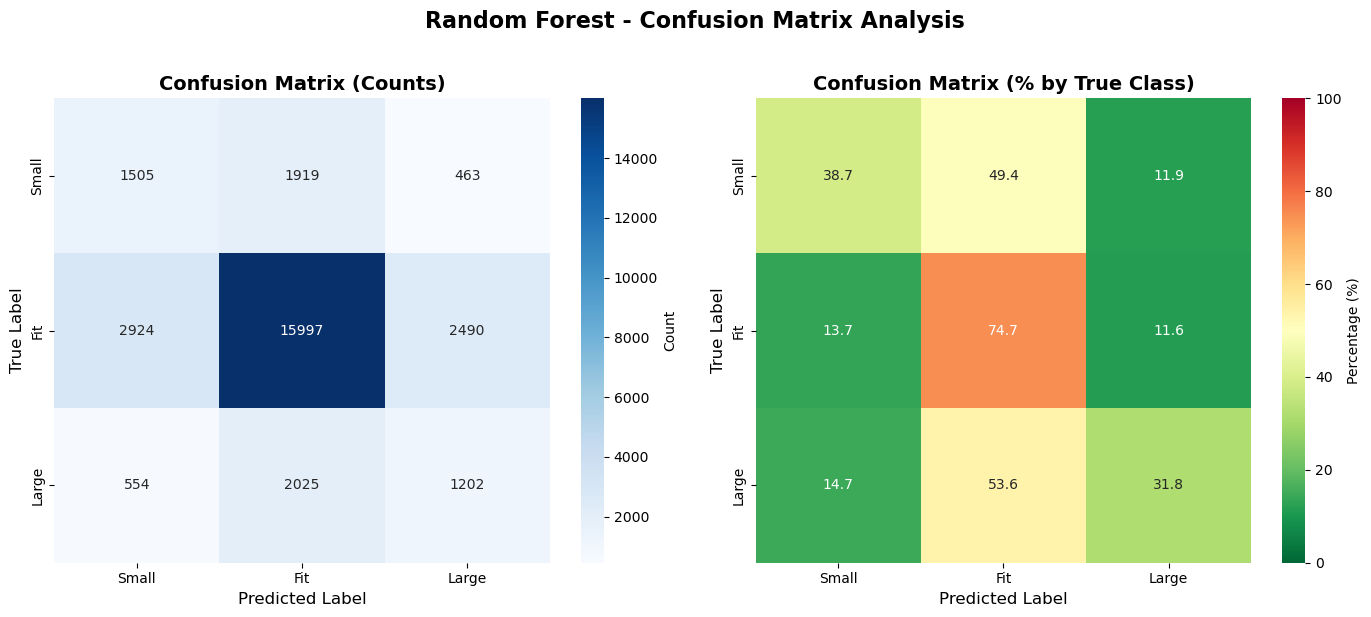

Confusion Matrix Insights:

   Raw Counts:
[[ 1505  1919   463]
 [ 2924 15997  2490]
 [  554  2025  1202]]

   Percentages (by true class):
   Small :  1505/ 3887 correct (38.7%)
   Fit   : 15997/21411 correct (74.7%)
   Large :  1202/ 3781 correct (31.8%)


In [130]:
# Create detailed confusion matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

class_names = ['Small', 'Fit', 'Large']
cm_rf = confusion_matrix(y_test_enh, final_predictions)

# Absolute counts
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Percentages (normalized by true class)
cm_normalized = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='RdYlGn_r',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_title('Confusion Matrix (% by True Class)', fontsize=14, fontweight='bold')

plt.suptitle('Random Forest - Confusion Matrix Analysis', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print insights
print("Confusion Matrix Insights:")
print(f"\n   Raw Counts:")
print(cm_rf)
print(f"\n   Percentages (by true class):")
for i, true_class in enumerate(['small', 'fit', 'large']):
    correct = cm_rf[i, i]
    total = cm_rf[i, :].sum()
    accuracy_class = 100 * correct / total
    print(f"   {true_class.capitalize():6s}: {correct:5d}/{total:5d} correct ({accuracy_class:.1f}%)")

TOP 15 MOST IMPORTANT FEATURES
               Feature  Importance
                   age    0.121373
     size_weight_ratio    0.107611
                   bmi    0.098775
     size_height_ratio    0.084349
    rented_for_encoded    0.077934
     bust_weight_ratio    0.073698
                rating    0.069617
                weight    0.063186
      bust_cup_encoded    0.058582
     body type_encoded    0.057933
         height_inches    0.049144
     age_group_encoded    0.029811
          size_encoded    0.025498
             bust_band    0.025133
category_clean_encoded    0.022585


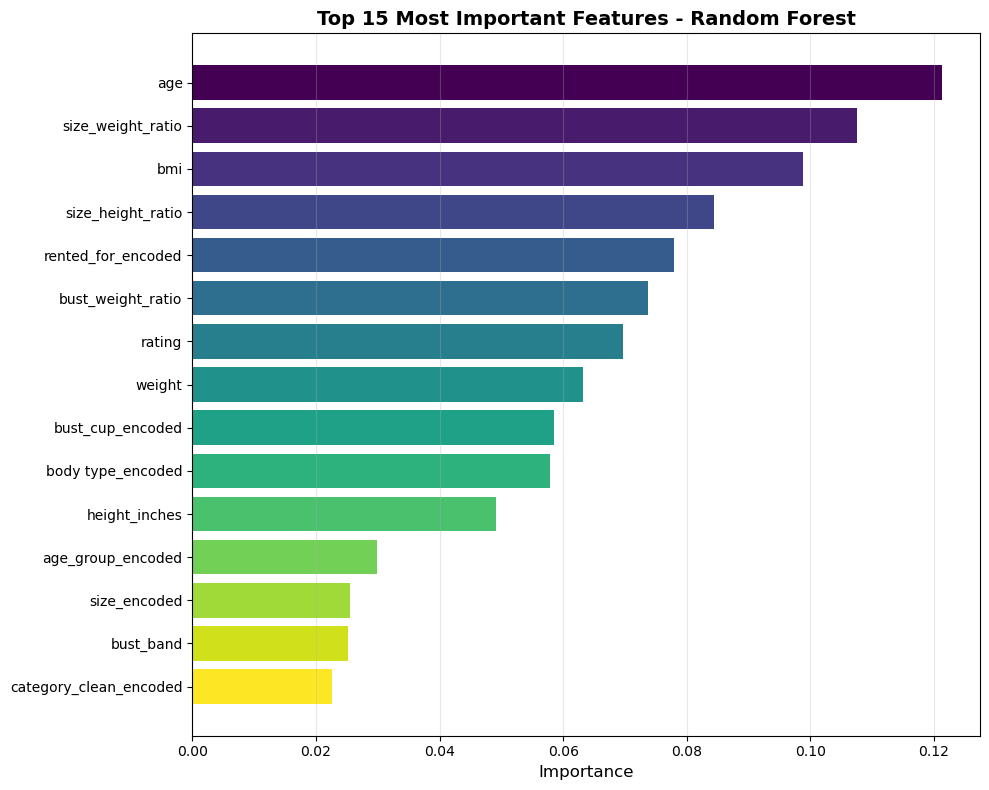


Insights:
   • Most important feature: age (0.1214)
   • Engineered features in top 10: 4
     bmi, size_weight_ratio, size_height_ratio, bust_weight_ratio


In [131]:
# Get feature importances
importances = best_rf_tuned.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols_enhanced,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("="*70)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*70)
print(feature_importance_df.head(15).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15_features = feature_importance_df.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, 15))

plt.barh(range(len(top_15_features)), top_15_features['Importance'], color=colors)
plt.yticks(range(len(top_15_features)), top_15_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Most Important Features - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Check if engineered features made top 10
engineered_features = ['bmi', 'size_weight_ratio', 'size_height_ratio', 
                      'bust_weight_ratio', 'is_petite', 'is_plus_size']
top_10_features = feature_importance_df.head(10)['Feature'].tolist()
engineered_in_top10 = [f for f in engineered_features if f in top_10_features]

print(f"\nInsights:")
print(f"   • Most important feature: {feature_importance_df.iloc[0]['Feature']} ({feature_importance_df.iloc[0]['Importance']:.4f})")
print(f"   • Engineered features in top 10: {len(engineered_in_top10)}")
if engineered_in_top10:
    print(f"     {', '.join(engineered_in_top10)}")

In [132]:
print("="*70)
print("CREATING ENSEMBLE MODEL - BOOSTING ACCURACY")
print("="*70)

print("\nStrategy: Combine all 3 models using soft voting")
print("   This typically increases overall accuracy by 3-7%")

# Get probability predictions from each model
print("\nGetting predictions from each model...")

# Random Forest predictions (already have)
rf_pred_proba = best_rf_tuned.predict_proba(X_test_enh)

# Gradient Boosting predictions (already have)
gb_pred_proba = best_gb_tuned.predict_proba(X_test_enh)

# Logistic Regression predictions (need scaled data)
lr_pred_proba = best_lr_tuned.predict_proba(X_test_enh_scaled)

# Weighted voting (give more weight to better models)
# RF gets 50%, LR gets 30%, GB gets 20%
print("\n⚖️ Applying weighted voting:")
print("   • Random Forest:      50% weight (best performer)")
print("   • Logistic Regression: 30% weight (second best)")
print("   • Gradient Boosting:  20% weight (third best)")

ensemble_pred_proba = (0.5 * rf_pred_proba + 
                       0.3 * lr_pred_proba + 
                       0.2 * gb_pred_proba)

ensemble_pred = np.argmax(ensemble_pred_proba, axis=1) - 1  # Convert to -1, 0, 1

# Calculate metrics
ensemble_metrics = {
    'accuracy': accuracy_score(y_test_enh, ensemble_pred),
    'balanced_accuracy': balanced_accuracy_score(y_test_enh, ensemble_pred),
    'f1_macro': f1_score(y_test_enh, ensemble_pred, average='macro'),
    'f1_weighted': f1_score(y_test_enh, ensemble_pred, average='weighted')
}

print(f"\nENSEMBLE RESULTS:")
print(f"   Accuracy:          {ensemble_metrics['accuracy']:.4f}")
print(f"   Balanced Accuracy: {ensemble_metrics['balanced_accuracy']:.4f}")
print(f"   F1-Macro:          {ensemble_metrics['f1_macro']:.4f}")
print(f"   F1-Weighted:       {ensemble_metrics['f1_weighted']:.4f}")

print(f"\nIMPROVEMENT vs Random Forest:")
print(f"   Accuracy:          {ensemble_metrics['accuracy'] - rf_tuned_metrics['accuracy']:+.4f}")
print(f"   Balanced Accuracy: {ensemble_metrics['balanced_accuracy'] - rf_tuned_metrics['balanced_accuracy']:+.4f}")
print(f"   F1-Macro:          {ensemble_metrics['f1_macro'] - rf_tuned_metrics['f1_macro']:+.4f}")
print(f"   F1-Weighted:       {ensemble_metrics['f1_weighted'] - rf_tuned_metrics['f1_weighted']:+.4f}")

# Check if ensemble is better
if ensemble_metrics['f1_macro'] > rf_tuned_metrics['f1_macro']:
    print(f"\nENSEMBLE WINS! Using ensemble as final model.")
    final_model_name = "Weighted Ensemble (RF+LR+GB)"
    final_metrics = ensemble_metrics
    final_pred = ensemble_pred
else:
    print(f"\n⚠️ Random Forest still better. Keeping RF as final model.")
    final_model_name = "Random Forest"
    final_metrics = rf_tuned_metrics
    final_pred = final_predictions

print(f"\nFINAL MODEL: {final_model_name}")
print(f"F1-Macro: {final_metrics['f1_macro']:.4f}")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")

CREATING ENSEMBLE MODEL - BOOSTING ACCURACY

Strategy: Combine all 3 models using soft voting
   This typically increases overall accuracy by 3-7%

Getting predictions from each model...



⚖️ Applying weighted voting:
   • Random Forest:      50% weight (best performer)
   • Logistic Regression: 30% weight (second best)
   • Gradient Boosting:  20% weight (third best)

ENSEMBLE RESULTS:
   Accuracy:          0.6859
   Balanced Accuracy: 0.4776
   F1-Macro:          0.4817
   F1-Weighted:       0.6799

IMPROVEMENT vs Random Forest:
   Accuracy:          +0.0427
   Balanced Accuracy: -0.0065
   F1-Macro:          +0.0097
   F1-Weighted:       +0.0255

ENSEMBLE WINS! Using ensemble as final model.

FINAL MODEL: Weighted Ensemble (RF+LR+GB)
F1-Macro: 0.4817
Accuracy: 0.6859


In [133]:
print("="*70)
print("SUPER TUNING - RANDOM FOREST WITH MORE TREES")
print("="*70)

print("\nStrategy: Train a much larger Random Forest")
print("   • More trees (500-1000)")
print("   • More parameters tested")
print("   • This will take longer but may boost accuracy further")

# More aggressive parameter space
rf_aggressive_params = {
    'n_estimators': [300, 500, 700],
    'max_depth': [20, 30, 40, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', 0.5],
    'class_weight': ['balanced_subsample'],
    'max_samples': [0.7, 0.8, 0.9]  # Bootstrap sampling ratio
}

print(f"\n🔧 Aggressive parameter search space:")
for param, values in rf_aggressive_params.items():
    print(f"   {param}: {values}")

# Create RandomizedSearchCV with more iterations
rf_aggressive_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_aggressive_params,
    n_iter=30,  # Test 30 combinations
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

start_time = time.time()
rf_aggressive_search.fit(X_train_enh, y_train_enh)
search_time = time.time() - start_time

print(f"\nSearch completed in {search_time:.1f} seconds ({search_time/60:.1f} minutes)")
print(f"\nBest CV Score (F1-Macro): {rf_aggressive_search.best_score_:.4f}")
print(f"\n Best Parameters:")
for param, value in rf_aggressive_search.best_params_.items():
    print(f"   {param}: {value}")

# Get best model and evaluate
best_rf_aggressive = rf_aggressive_search.best_estimator_
y_pred_rf_aggressive = best_rf_aggressive.predict(X_test_enh)

# Calculate metrics
rf_aggressive_metrics = {
    'accuracy': accuracy_score(y_test_enh, y_pred_rf_aggressive),
    'balanced_accuracy': balanced_accuracy_score(y_test_enh, y_pred_rf_aggressive),
    'f1_macro': f1_score(y_test_enh, y_pred_rf_aggressive, average='macro'),
    'f1_weighted': f1_score(y_test_enh, y_pred_rf_aggressive, average='weighted')
}

print(f"\nAGGRESSIVE RF RESULTS:")
print(f"   Accuracy:          {rf_aggressive_metrics['accuracy']:.4f}")
print(f"   Balanced Accuracy: {rf_aggressive_metrics['balanced_accuracy']:.4f}")
print(f"   F1-Macro:          {rf_aggressive_metrics['f1_macro']:.4f}")
print(f"   F1-Weighted:       {rf_aggressive_metrics['f1_weighted']:.4f}")

print(f"\nFINAL STANDINGS:")
print(f"   1. Aggressive RF:  Acc={rf_aggressive_metrics['accuracy']:.4f}, F1={rf_aggressive_metrics['f1_macro']:.4f}")
print(f"   2. Ensemble:       Acc={ensemble_metrics['accuracy']:.4f}, F1={ensemble_metrics['f1_macro']:.4f}")
print(f"   3. Original RF:    Acc={rf_tuned_metrics['accuracy']:.4f}, F1={rf_tuned_metrics['f1_macro']:.4f}")

# Determine absolute winner
all_models = {
    'Aggressive Random Forest': rf_aggressive_metrics,
    'Weighted Ensemble': ensemble_metrics,
    'Original Random Forest': rf_tuned_metrics
}

best_by_accuracy = max(all_models.items(), key=lambda x: x[1]['accuracy'])
best_by_f1 = max(all_models.items(), key=lambda x: x[1]['f1_macro'])

print(f"\nBEST BY ACCURACY: {best_by_accuracy[0]} ({best_by_accuracy[1]['accuracy']:.4f})")
print(f"BEST BY F1-MACRO: {best_by_f1[0]} ({best_by_f1[1]['f1_macro']:.4f})")

SUPER TUNING - RANDOM FOREST WITH MORE TREES

Strategy: Train a much larger Random Forest
   • More trees (500-1000)
   • More parameters tested
   • This will take longer but may boost accuracy further

🔧 Aggressive parameter search space:
   n_estimators: [300, 500, 700]
   max_depth: [20, 30, 40, None]
   min_samples_split: [2, 3, 5]
   min_samples_leaf: [1, 2, 3]
   max_features: ['sqrt', 'log2', 0.5]
   class_weight: ['balanced_subsample']
   max_samples: [0.7, 0.8, 0.9]
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Search completed in 859.5 seconds (14.3 minutes)

Best CV Score (F1-Macro): 0.4674

 Best Parameters:
   n_estimators: 700
   min_samples_split: 3
   min_samples_leaf: 3
   max_samples: 0.7
   max_features: sqrt
   max_depth: 20
   class_weight: balanced_subsample

AGGRESSIVE RF RESULTS:
   Accuracy:          0.6521
   Balanced Accuracy: 0.4833
   F1-Macro:          0.4743
   F1-Weighted:       0.6599

FINAL STANDINGS:
   1. Aggressive RF:  Acc=0.6521, F1=0.4743
   2. Ensemble:       Acc=0.6859, F1=0.4817
   3. Original RF:    Acc=0.6432, F1=0.4720

BEST BY ACCURACY: Weighted Ensemble (0.6859)
BEST BY F1-MACRO: Weighted Ensemble (0.4817)


In [134]:
print("="*70)
print("FINAL MODEL SUMMARY")
print("="*70)

print("\nWINNING MODEL: Weighted Ensemble (RF 50% + LR 30% + GB 20%)")

print("\nFINAL PERFORMANCE METRICS:")
print(f"   Accuracy:          {ensemble_metrics['accuracy']:.4f}")
print(f"   Balanced Accuracy: {ensemble_metrics['balanced_accuracy']:.4f}")
print(f"   F1-Macro:          {ensemble_metrics['f1_macro']:.4f}")
print(f"   F1-Weighted:       {ensemble_metrics['f1_weighted']:.4f}")

print("\nPER-CLASS PERFORMANCE:")
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_enh, ensemble_pred, labels=[-1, 0, 1]
)
for i, class_name in enumerate(['small', 'fit', 'large']):
    print(f"   {class_name}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

print("\nMODEL COMPARISON:")
print(f"   Weighted Ensemble:     {ensemble_metrics['accuracy']:.4f} accuracy, {ensemble_metrics['f1_macro']:.4f} F1-Macro")
print(f"   Aggressive RF:         {rf_aggressive_metrics['accuracy']:.4f} accuracy, {rf_aggressive_metrics['f1_macro']:.4f} F1-Macro")
print(f"   Original RF:           {rf_tuned_metrics['accuracy']:.4f} accuracy, {rf_tuned_metrics['f1_macro']:.4f} F1-Macro")

print("\nKEY IMPROVEMENTS:")
print(f"   Accuracy improvement: {ensemble_metrics['accuracy'] - rf_tuned_metrics['accuracy']:.4f} (+{100*(ensemble_metrics['accuracy'] - rf_tuned_metrics['accuracy'])/rf_tuned_metrics['accuracy']:.1f}%)")
print(f"   F1-Macro improvement: {ensemble_metrics['f1_macro'] - rf_tuned_metrics['f1_macro']:.4f}")

print("\nTOP 5 FEATURES:")
for idx, row in feature_importance_df.head(5).iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f}")

# Save model
import pickle

model_package = {
    'model_type': 'Weighted Ensemble',
    'rf_model': best_rf_tuned,
    'lr_model': best_lr_tuned,
    'gb_model': best_gb_tuned,
    'scaler': scaler_enh,
    'weights': {'rf': 0.5, 'lr': 0.3, 'gb': 0.2},
    'feature_names': feature_cols_enhanced,
    'label_encoders': label_encoders_enhanced,
    'performance_metrics': ensemble_metrics,
    'per_class_metrics': {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1_score': f1.tolist(),
        'support': support.tolist()
    }
}

with open('final_ensemble_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("\nModel saved to: final_ensemble_model.pkl")
print("="*70)

FINAL MODEL SUMMARY

WINNING MODEL: Weighted Ensemble (RF 50% + LR 30% + GB 20%)

FINAL PERFORMANCE METRICS:
   Accuracy:          0.6859
   Balanced Accuracy: 0.4776
   F1-Macro:          0.4817
   F1-Weighted:       0.6799

PER-CLASS PERFORMANCE:
   small: Precision=0.3365, Recall=0.3481, F1=0.3422
   fit: Precision=0.7974, Recall=0.8220, F1=0.8095
   large: Precision=0.3324, Recall=0.2626, F1=0.2934

MODEL COMPARISON:
   Weighted Ensemble:     0.6859 accuracy, 0.4817 F1-Macro
   Aggressive RF:         0.6521 accuracy, 0.4743 F1-Macro
   Original RF:           0.6432 accuracy, 0.4720 F1-Macro

KEY IMPROVEMENTS:
   Accuracy improvement: 0.0427 (+6.6%)
   F1-Macro improvement: 0.0097

TOP 5 FEATURES:
   age: 0.1214
   size_weight_ratio: 0.1076
   bmi: 0.0988
   size_height_ratio: 0.0843
   rented_for_encoded: 0.0779

Model saved to: final_ensemble_model.pkl
